# All Spectrogram Code Setup

In [122]:
%matplotlib inline
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, stats
from sklearn.decomposition import NMF
import pandas as pd

def get_all_pat_chn_trials(base_data_dir, patient_num, session_idx, tot_num_channels, 
                           core_cat, trials_type="category"):
    """Get all trials for each channel for a given category"""    
    
    patient_ref = f"P{patient_num:02}"
    #print("patient_ref", patient_ref, sep =": ")
    patient_data_dir = os.path.join(base_data_dir, f"{patient_ref}_specgram", 
                                    f"{trials_type}", 
                                    f"session_{session_idx:02}",
                                    f"{core_cat}")
    #print("patient_data_dir", patient_data_dir, sep =": ")
    patient_csv_refs = [os.path.join(patient_data_dir, f"{patient_ref}-ses-{session_idx:02}-chn-{channel_idx + 1:02}-{core_cat}.csv") 
                        for channel_idx in tot_num_channels]
    #print("patient_csv_refs", patient_csv_refs[0], sep =": ")
    all_patient_trials = [np.loadtxt(fname = patient_csv_ref, skiprows = 1, delimiter = ",") for 
                          patient_csv_ref in patient_csv_refs]
    return all_patient_trials

def samp_idx_without_replace(np_arr, samp_prop=0.5, sample_rows=False):
    """Returns a list of unique row indices from the total number of trials"""
    if sample_rows:
        # sample the number of rows
        sample_type = 0
    else:
        # sample the number of columns
        sample_type = 1
    tot_num_idxs = np_arr.shape[sample_type]
    samp_num_rows = int(np.floor(tot_num_idxs * samp_prop))
    return sorted(random.sample(range(tot_num_idxs), samp_num_rows))

def erp_gen_spectrogram(x, fs = 1e3, window = 'hann', nperseg = 128, noverlap = 96, log_Sxx=False):
    """Generate the spectrogram and return the modulus (or log modulus)"""
    f, t, Sxx = signal.spectrogram(x = x, fs = fs, window = window, nperseg = nperseg, noverlap = noverlap)
    if log_Sxx:
        Sxx = np.log(Sxx)
    return f, t, Sxx

def specgram_trials(arr_all_trials, fs=1e3, window='hann', nperseg=128, 
                    trials_samp_idx=None, filter_row_idx=None, log_Sxx=False):
    """Produce a combined list of spectrograms concatenated by frequency (horizontally)"""
    if trials_samp_idx is None:
        # Produce spectrograms for all of the trials
        all_trial_idx = range(arr_all_trials.shape[0])
        trial_specgrams = [erp_gen_spectrogram(x = arr_all_trials[idx], fs = fs, window = window, nperseg = nperseg, 
                                               log_Sxx=log_Sxx)[2] for idx in all_trial_idx]
    else:
        # Produce spectrograms for only the specified trials (by trial indices)
        trial_specgrams = [erp_gen_spectrogram(x = arr_all_trials[idx], fs = fs, window = window, nperseg = nperseg, 
                                               log_Sxx=log_Sxx)[2] for idx in trials_samp_idx]
    
    # Concatenate the combined spectrograms across time i.e. horizontally
    comb_specgram = np.hstack(trial_specgrams)
    
    # Filter the rows of the combined spectrogram    
    if filter_row_idx is None:
        # Don't filter any rows in the combined spectrogram
        comb_specgram = comb_specgram
    else:
        comb_specgram = comb_specgram[filter_row_idx]
    return comb_specgram

def specgram_wrapper(arr_all_trials, tot_num_channels, fs=1e3, window='hann', nperseg=128, 
                     trials_samp_idx=None, filter_row_idx=None, log_Sxx=False):
    """Wrapper to produce spectrograms across all trials (or samples thereof) and the specified
       channels for the particular patient"""
    all_channels_specgrams = [specgram_trials(arr_all_trials=arr_all_trials[channel_idx],
                                              fs = fs, window = window, nperseg = nperseg,
                                              trials_samp_idx=trials_samp_idx, filter_row_idx=filter_row_idx,
                                              log_Sxx=log_Sxx) 
                              for channel_idx in range(len(tot_num_channels))]
    comb_all_channels_specgrams = np.hstack(all_channels_specgrams)
    return comb_all_channels_specgrams

def time_sample_specgram(comb_specgram, time_samp_idx):
    """samples a combined spectrogram of signals (horizontally stacked) and samples by time i.e. shortens by column"""
    return comb_specgram[:, time_samp_idx]    

def nmf_specgrams(comb_specgram, n_components=5, init='random', random_state=0, beta_loss='itakura-saito', solver = 'mu', max_iter=200):
    model = NMF(n_components=n_components, init=init, random_state=random_state, beta_loss=beta_loss, solver=solver, max_iter=max_iter)
    W = model.fit_transform(X=comb_specgram)
    H = model.components_
    return W, H

def nmf_wrapper(comb_all_channels_specgrams, n_components=5, init='random', random_state=0, 
                beta_loss='itakura-saito', solver = 'mu', max_iter=200):
    W, H = nmf_specgrams(comb_all_channels_specgrams, n_components=n_components, init=init, random_state=random_state, 
                         beta_loss=beta_loss, solver=solver, max_iter=max_iter)
    print("V", comb_all_channels_specgrams.shape, sep = ": ")
    print("W", W.shape, sep = ": ")
    print("H", H.shape, sep = ": ")
    return comb_all_channels_specgrams, W, H

### Plot the "basis" vectors i.e. columns of W

def plotW(W, log=True, x_ticks_l=None):
    if log:
        W_plt = np.log(W)
    else:
        W_plt = W
    n_components = W.shape[1]    
    for n in range(W.shape[1]):
        plt.style.use('seaborn')
        plt.figure(figsize=(20, 16), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(np.ceil(n_components/2.0), 2, n+1)
        plt.plot(W_plt[:,n])
        plt.title(f'Plot of W Component {n + 1}', fontsize=16)
        #plt.ylim(-2, W_plt.max())
        if x_ticks_l is None:
            plt.xlim(0, W_plt.shape[0])
        else:
            plt.xticks(range(0, W_plt.shape[0]), x_ticks_l, rotation='vertical')
        plt.ylabel(f'Component {n + 1}')

### Plot the rows of H i.e. the temporal activations

def plotH(H, log=False, y_ticks_l=None):
    print(H.shape[1])
    if log:
        H_plt = np.log(H)
    else:
        H_plt = H
    n_components = H.shape[0]    
    for n in range(H_plt.shape[0]):
        plt.style.use('seaborn')
        plt.figure(figsize=(16, 14), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(np.ceil(n_components/2.0), 2, n+1)
        plt.title(f'Plot of H Component {n + 1}', fontsize=16)
        plt.plot(H_plt[n])
        #if y_ticks_l is None:
        #    plt.ylim(0, H_plt.shape[1])
        #else:
        #    plt.yticks(range(0, H_plt.shape[1]), np.around(y_ticks_l, decimals=-1), rotation='vertical')
        #plt.ylim(0, H.max())
        plt.xlim(0, H_plt.shape[1])
        plt.ylabel(f'Component {n + 1}')
        
def entire_specgram_nmf_wrapper(base_data_dir, core_cat, trials_type,
                                patient_num, session_idx, tot_num_channels, samp_trial_pop, 
                                time_samp_prop=0.2,
                                filter_row_idx=None, 
                                log_Sxx=False,
                                fs=1e3, window='hann', nperseg=128,
                                n_components=8, 
                                init='random', 
                                random_state=0, 
                                beta_loss='itakura-saito', 
                                solver = 'mu',
                                max_iter=400):
    
    # Get all the channels and trials (DONE)
    all_patient_trials = get_all_pat_chn_trials(base_data_dir=base_data_dir, patient_num=patient_num, 
                                                session_idx=session_idx, tot_num_channels=tot_num_channels, 
                                                core_cat=core_cat, trials_type=trials_type)

    trials_samp_idx = samp_idx_without_replace(np_arr=all_patient_trials[0], samp_prop=samp_trial_pop, 
                                               sample_rows=True)
    print(len(trials_samp_idx))

    # Fit the spectrograms and hstack the spectrograms
    comb_all_channels_specgrams = specgram_wrapper(arr_all_trials=all_patient_trials, 
                                                   trials_samp_idx=trials_samp_idx, 
                                                   tot_num_channels=tot_num_channels,
                                                   fs=fs, window=window, nperseg=nperseg,
                                                   filter_row_idx=filter_row_idx, 
                                                   log_Sxx=log_Sxx)

    # randomly sample across time
    time_samp_idx = samp_idx_without_replace(np_arr=comb_all_channels_specgrams, 
                                             samp_prop=time_samp_prop, 
                                             sample_rows=False)
    
    print("comb_all_channels_specgrams:", comb_all_channels_specgrams.shape, sep = " ")
    print("time_samp_idx length:", len(time_samp_idx), sep = " ")

    comb_specgram_time_sample = time_sample_specgram(comb_specgram=comb_all_channels_specgrams, 
                                                     time_samp_idx=time_samp_idx)
    
    print("comb_specgram_time_sample:", comb_specgram_time_sample.shape, sep=" ")
    
    print("STARTING NMF...")
    
    # perform NMF
    V, W, H = nmf_wrapper(comb_all_channels_specgrams=comb_specgram_time_sample, 
                          n_components=n_components,
                          init=init, 
                          random_state=random_state, 
                          beta_loss=beta_loss, 
                          solver=solver,
                          max_iter=max_iter)
    
    print("NMF COMPLETE!")
    
    return V, W, H        

# Channel 1 - P35, Faces, Session 1

In [2]:
base_data_dir = "/Users/shamindras/PERSONAL/LEARNING/REPOS/neuroada_analysis/data/localizer_erp"
patient_num = 35
tot_num_channels = range(4)
trials_type = "category"
session_idx = 1
core_cat = "Faces"

### Import all of the trials data for P35, Faces for just channel 1 -  Session 1

In [3]:
# Get all the channels and trials (DONE)
p35_chn01_faces_tr = get_all_pat_chn_trials(base_data_dir=base_data_dir, patient_num=patient_num, 
                                            session_idx=session_idx, tot_num_channels=tot_num_channels, 
                                            core_cat=core_cat, trials_type=trials_type)
p35_chn01_faces_tr[0].shape

(83, 1500)

#### Comments
- This makes sense, just 83 **Face** trials in channel 1 for P35 in session 1.
- Let's extract the first trial only to test out the spectrogram fit.

In [4]:
p35_chn01_faces_tr_01 = p35_chn01_faces_tr[0][0]
p35_chn01_faces_tr_01.shape

(1500,)

In [60]:
p35_chn01_faces_tr_01
len(t)

8

#### Comments

- Good, data extracted for the full 1500 second recording

### Fit the spectrogram

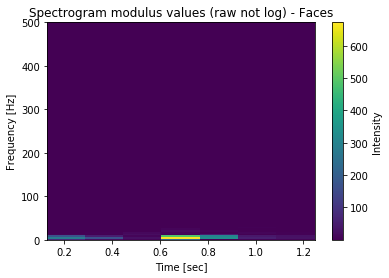

In [6]:
# Fit the spectrogram - no log
f, t, Sxx = erp_gen_spectrogram(x = p35_chn01_faces_tr_01, fs = 1e3, 
                                window = 'hann', nperseg = 256, noverlap = 96, log_Sxx=False)

# Plot the spectrogram
plt.pcolormesh(t, f, Sxx)
plt.title(f"Spectrogram modulus values (raw not log) - {core_cat}")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar().set_label('Intensity')
plt.show()

In [62]:
Sxx.shape

(129, 8)

### Plot the **log** of the modulus spectrogram values

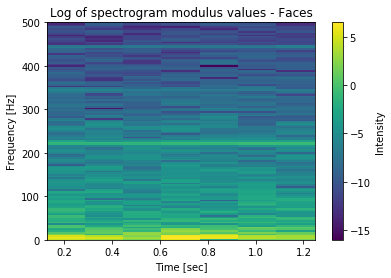

In [7]:
plt.pcolormesh(t, f, np.log(Sxx))
plt.title(f"Log of spectrogram modulus values - {core_cat}")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar().set_label('Intensity')
plt.show()

In [11]:
f[26]
#len(t)

101.5625

# 85 Channels - P35, Faces, Session 1

### Perform NMF for P35 - 85 Channels, Faces, Session 1 
#### (100% sampling of trials, 20% sampling of time)

In [128]:
base_data_dir = "/Users/shamindras/PERSONAL/LEARNING/REPOS/neuroada_analysis/data/localizer_erp"
patient_num = 35
#tot_num_channels = list(range(9)) + list(range(19, 20)) + list(range(27, 56)) + list(range(27, 56)) + list(range(76, 85))
#tot_num_channels = list(range(30))
tot_num_channels = list(range(25)) + list(range(28, 30))
trials_type = "category"
session_idx = 1
core_cat = "Faces"
filter_row_idx=range(27)
fs = 1e3
window = 'hann'
nperseg = 256

In [129]:
V, W, H = entire_specgram_nmf_wrapper(base_data_dir=base_data_dir, core_cat=core_cat, trials_type=trials_type,
                                      patient_num=patient_num, session_idx=session_idx, 
                                      tot_num_channels=tot_num_channels, 
                                      samp_trial_pop=1.0, # 100% sampling of trials
                                      time_samp_prop=1.0, # 20% sampling of time)
                                      filter_row_idx=filter_row_idx,
                                      fs=fs, window=window, nperseg=nperseg,
                                      log_Sxx=False,
                                      n_components=8, 
                                      init='random', 
                                      random_state=0, 
                                      beta_loss='itakura-saito', 
                                      solver = 'mu',
                                      max_iter=400)

83
comb_all_channels_specgrams: (27, 17928)
time_samp_idx length: 17928
comb_specgram_time_sample: (27, 17928)
STARTING NMF...
V: (27, 17928)
W: (27, 8)
H: (8, 17928)
NMF COMPLETE!


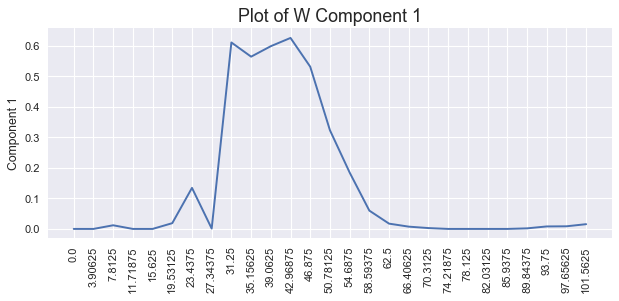

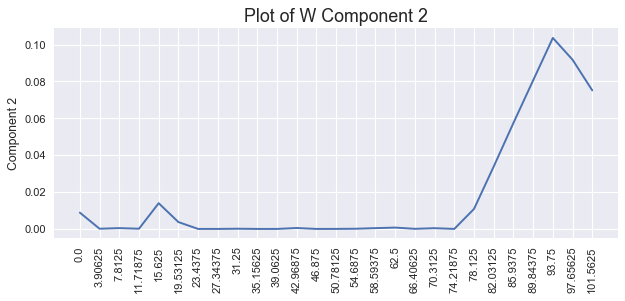

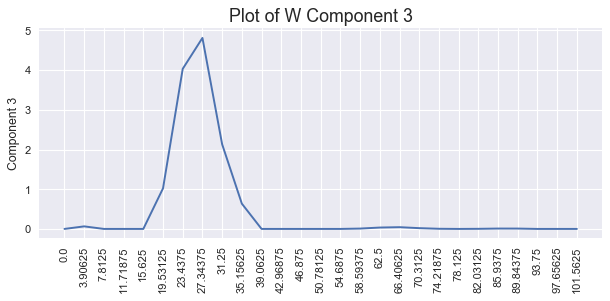

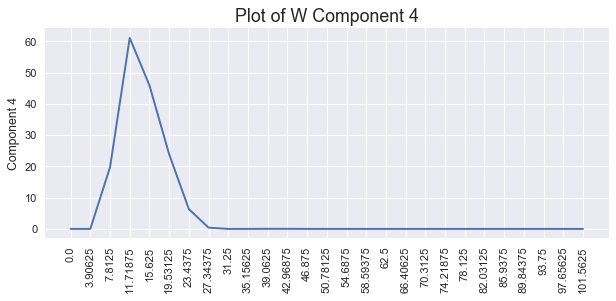

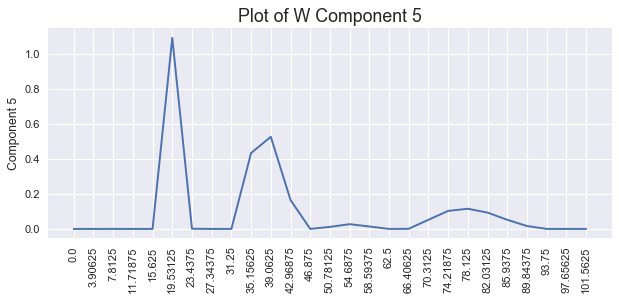

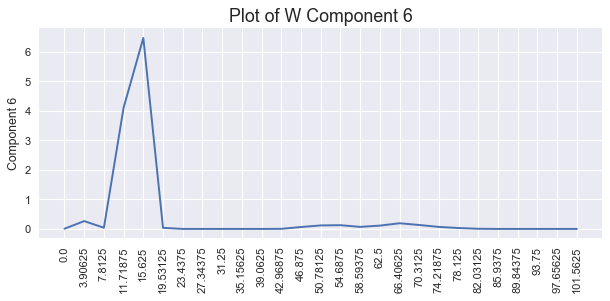

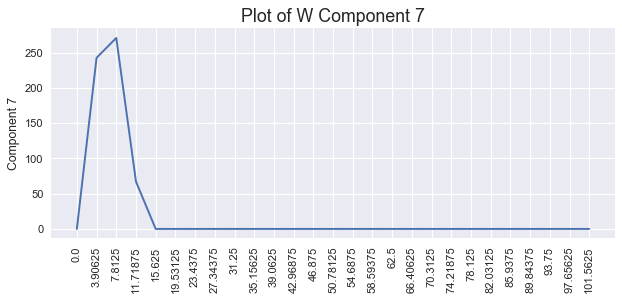

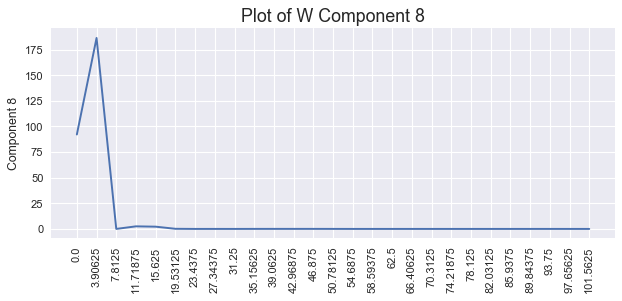

In [130]:
#freq_ticks = np.around(np.linspace(0, 100, num=len(filter_row_idx)), decimals=0)
freq_ticks = f[filter_row_idx]
#freq_ticks
plotW(W = W, log=False, x_ticks_l=freq_ticks)

In [84]:
len(H[0])
h0 = H[0]
np.mean(h0)
h0_std = np.std(h0)
h0[h0 > 30*h0_std]
outlier_idx = (h0 > 45*h0_std).nonzero()
outlier_idx
#h0[h0 > 70*h0_std]

(array([16608, 16664]),)

In [83]:
len(H[0])
V.shape
#V[:, outlier_idx]

(27, 19920)

In [89]:
16609 // V.shape[0]

615

In [90]:
615/30

20.5

In [94]:
H[0, 19920]

IndexError: index 19920 is out of bounds for axis 1 with size 19920

In [125]:
test = pd.DataFrame(data=H[0], columns=["val"])
stats.percentileofscore(test['val'],800)

100.0

In [106]:
def get_outlier_indices(outlier_idx, specgram_width, num_trials, num_channels):
    outlier_loc = outlier_idx + 1
    channel_num = np.ceil(outlier_loc/(specgram_width * num_trials))
    channel_idx = channel_num - 1
    trial_num = np.ceil((outlier_loc % (channel_idx * num_trials))/specgram_width)
    trial_idx = trial_num - 1
    return channel_num, channel_idx, trial_num, trial_idx

In [120]:
channel_num, channel_idx, trial_num, trial_idx = get_outlier_indices(outlier_idx=16608, 
                                                                     specgram_width=8, 
                                                                     num_trials=83, 
                                                                     num_channels=30)
print("channel_num: ", channel_num)
print("channel_idx: ", channel_idx) 
print("trial_num: ", trial_num)
print("trial_idx: ", trial_idx)

channel_num:  26.0
channel_idx:  25.0
trial_num:  2.0
trial_idx:  1.0


In [ ]:
outlier_idx <- 16608
outlier_loc <- outlier_idx + 1

specgram_width <- 8
num_trials <- 83
num_channels <- 30

# channel number
channel_num <- ceiling(outlier_loc/(specgram_width * num_trials))
channel_num
# channel index
channel_idx <- channel_num - 1
channel_idx
# trial number
trial_num <- ceiling((outlier_loc%%(channel_idx * num_trials))/specgram_width)
trial_num
# trial index
trial_idx <- trial_num - 1
trial_idx

17928


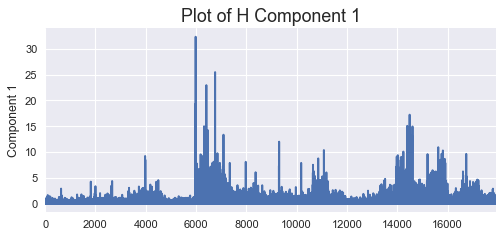

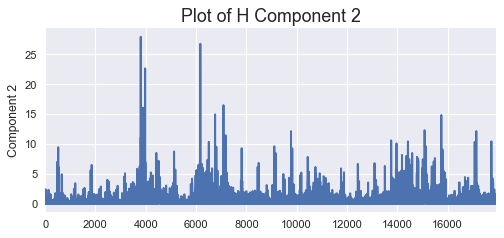

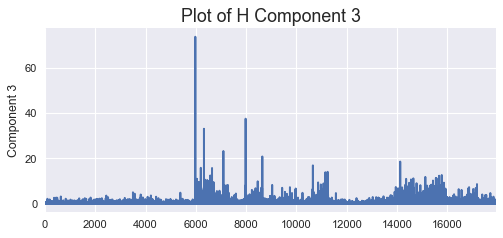

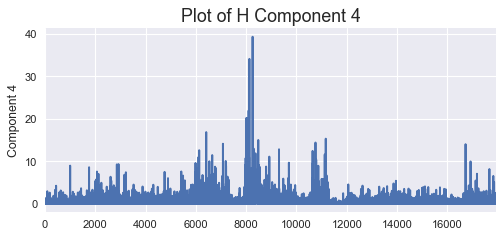

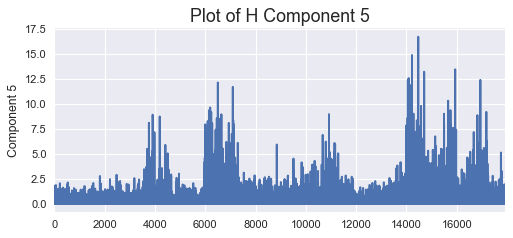

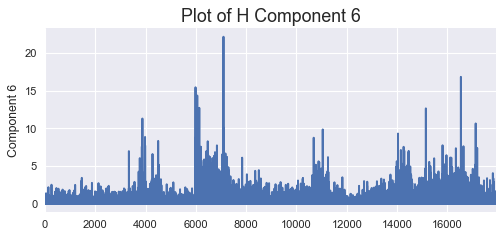

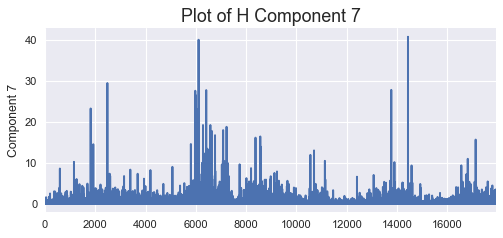

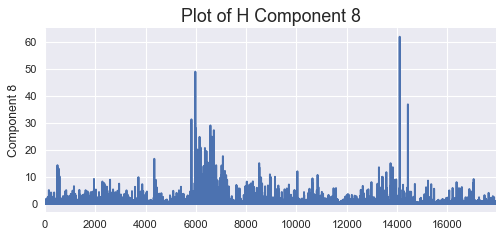

In [131]:
plotH(H = H, log=False, y_ticks_l=None)

# Stability Testing of NMF - Sample across Trials
### Replicate NMF 20 times 
#### (70% sampling of trials, 20% sampling of time)

In [ ]:
num_reps = 20
results_NMF = [entire_specgram_nmf_wrapper(base_data_dir=base_data_dir, core_cat=core_cat, trials_type=trials_type,
                                      patient_num=patient_num, session_idx=session_idx, 
                                      tot_num_channels=tot_num_channels, 
                                      samp_trial_pop=0.7, # 70% sampling of trials
                                      time_samp_prop=0.2, # 20% sampling of time)
                                      filter_row_idx=filter_row_idx,
                                      fs=fs, window=window, nperseg=nperseg,
                                      log_Sxx=False,
                                      n_components=8, 
                                      init='random', 
                                      random_state=0, 
                                      beta_loss='itakura-saito', 
                                      solver = 'mu',
                                      max_iter=400) for i in range(num_reps)]

### Create the tensor of all the $W$ matrices

In [ ]:
W_mats = [results_NMF[i][1] for i in range(len(results_NMF))]
W_tens = np.dstack(tup=W_mats)
W_tens.shape
W_tens[:, 0, :].shape
len(W_mats)
#W_mats[9].shape

In [ ]:
def repl_check_W(W_tens, W_all_trials, component, x_ticks_l):
    plt.figure(figsize=(20, 16), dpi= 80, facecolor='w', edgecolor='k')
    num_replicates = W_tens.shape[1]
    plt.title(f'Plot of W Component {component + 1}', fontsize=16)    
    legend_names = [f'Comp {n + 1}' for n in range(num_replicates)]    
    plt.plot(W_tens[:, component, :])
    plt.xticks(range(0, W_all_trials.shape[0]), x_ticks_l, rotation='vertical')
    plt.legend(legend_names, loc=9, bbox_to_anchor=(0.5, -0.1), ncol = 10)
    plt.show()   
    
    plt.figure(figsize=(20, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(W_all_trials[:, component])
    plt.title(f'Plot of W Component {component + 1}', fontsize=16)    
    plt.xticks(range(0, W_all_trials.shape[0]), x_ticks_l, rotation='vertical')
    plt.ylabel(f'Component {component + 1}')
    plt.show()

repl_check_W(W_tens=W_tens, W_all_trials=W, component=0, x_ticks_l=freq_ticks)

### Replicate NMF 20 times 
#### (100% sampling of trials, 20% sampling of time)

In [ ]:
num_reps = 20
results_NMF1 = [entire_specgram_nmf_wrapper(base_data_dir=base_data_dir, core_cat=core_cat, trials_type=trials_type,
                                      patient_num=patient_num, session_idx=session_idx, 
                                      tot_num_channels=tot_num_channels, 
                                      samp_trial_pop=1.0, # 100% sampling of trials
                                      time_samp_prop=0.2, # 20% sampling of time)
                                      filter_row_idx=filter_row_idx,
                                      fs=fs, window=window, nperseg=nperseg,
                                      log_Sxx=False,
                                      n_components=8, 
                                      init='random', 
                                      random_state=0, 
                                      beta_loss='itakura-saito', 
                                      solver = 'mu',
                                      max_iter=400) for i in range(num_reps)]

In [ ]:
#results_NMF1 = results_NMF
W_mats1 = [results_NMF1[i][1] for i in range(len(results_NMF1))]
W_tens1 = np.dstack(tup=W_mats1)
W_tens1.shape
W_tens1[:, 0, :].shape
#len(W_mats)
#W_mats[9].shape

In [ ]:
repl_check_W(W_tens=W_tens1, W_all_trials=W, component=0, x_ticks_l=freq_ticks)

## New tasks - for Discussion
- How many frequency bands to choose? Is 8 reasonable, can we select these in a more principled way?
- What are the highest observed frequencies in the brain at which something interesting is observed to occur?
- Check stability when trials are sampled and how to deal with this?
- Combine sessions for a single patient
- Combine patients at some point?
- Consider the time lag in the ERP signal?
- AG: Taper - wavelet basis. Different frequencies
- AG: Sample equally in frequencies and time